## Imports

In [2]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

import time
from numba import njit


##  Navier Stokes Equation

## Pure python

In [3]:
def build_up_b_pure(b, rho, dt, u, v, dx, dy):
    row, col = b.shape
    for i in range(1,row-1):
        for j in range(1,col-1):
            b[i,j]=rho*(dx*dy)**2*(((u[i+1,j]-u[i-1,j])/(2*dx)+(v[i,j+1]-v[i,j-1])/(2*dy))/dt-(u[i+1,j]-u[i-1,j])**2/(4*dx*dx)-2*(u[i,j+1]-u[i,j-1])*(v[i+1,j]-v[i-1,j])/(4*dy*dx)-(v[i,j+1]-v[i,j-1])**2/(4*dy*dy))/(2*(dx**2+dy**2))

    return b

def pressure_poisson_pure(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    row, col = b.shape
    for i in range(1,row-1):
        for j in range(1,col-1):
            p[i,j]=((pn[i+1,j]+pn[i-1,j])*dy**2+(pn[i,j+1]+pn[i,j-1])*dy**2)/(2*(dx**2+dy**2))-b[i,j]
    p[0,:]=p[1,:]
    p[-1,:]=p[-2,:]
    p[:,0]=p[:,1]
    p[:,-1]=0
        
    return p

def cavity_flow_pure(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    #the initial condition at y=2
    u[:,-1]=1
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    row, col = b.shape
    for k in range(nt):
        un=u.copy()
        vn=v.copy()
        for i in range(1,row-1):
            for j in range(1,col-1):
                u[i,j]=un[i,j]-un[i,j]*dt*(un[i,j]-un[i,j-1])/dx-vn[i,j]*dt*(un[i,j]-un[i,j-1])/dy-dt*(p[i+1,j]-p[i-1,j])/(rho*2*dx)+nu*(dt*(un[i+1,j]-2*un[i,j]+un[i-1,j])/dx**2+dt*(un[i,j+1]-2*un[i,j]+un[i,j-1])/dy**2)
                v[i,j]=vn[i,j]-un[i,j]*dt*(vn[i,j]-vn[i,j-1])/dx-vn[i,j]*dt*(vn[i,j]-vn[i,j-1])/dy-dt*(p[i,j+1]-p[i,j-1])/(rho*2*dx)+nu*(dt*(vn[i+1,j]-2*vn[i,j]+vn[i-1,j])/dx**2+dt*(vn[i,j+1]-2*vn[i,j]+vn[i,j-1])/dy**2)
        b=build_up_b_pure(b, rho, dt, u, v, dx, dy)
        p=pressure_poisson_pure(p, dx, dy, b)
    
        
        
    return u, v, p

## Numba accelerator

In [4]:
@njit(fastmath=True)
def build_up_b_numba(b, rho, dt, u, v, dx, dy):
    row, col = b.shape
    for i in range(1,row-1):
        for j in range(1,col-1):
            b[i,j]=rho*(dx*dy)**2*(((u[i+1,j]-u[i-1,j])/(2*dx)+(v[i,j+1]-v[i,j-1])/(2*dy))/dt-(u[i+1,j]-u[i-1,j])**2/(4*dx*dx)-2*(u[i,j+1]-u[i,j-1])*(v[i+1,j]-v[i-1,j])/(4*dy*dx)-(v[i,j+1]-v[i,j-1])**2/(4*dy*dy))/(2*(dx**2+dy**2))

    return b
@njit(fastmath=True)
def pressure_poisson_numba(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    row, col = b.shape
    for i in range(1,row-1):
        for j in range(1,col-1):
            p[i,j]=((pn[i+1,j]+pn[i-1,j])*dy**2+(pn[i,j+1]+pn[i,j-1])*dy**2)/(2*(dx**2+dy**2))-b[i,j]
    p[0,:]=p[1,:]
    p[-1,:]=p[-2,:]
    p[:,0]=p[:,1]
    p[:,-1]=0
        
    return p
@njit(fastmath=True)
def cavity_flow_numba(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    #the initial condition at y=2
    u[:,-1]=1
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    row, col = b.shape
    for k in range(nt):
        un=u.copy()
        vn=v.copy()
        for i in range(1,row-1):
            for j in range(1,col-1):
                u[i,j]=un[i,j]-un[i,j]*dt*(un[i,j]-un[i,j-1])/dx-vn[i,j]*dt*(un[i,j]-un[i,j-1])/dy-dt*(p[i+1,j]-p[i-1,j])/(rho*2*dx)+nu*(dt*(un[i+1,j]-2*un[i,j]+un[i-1,j])/dx**2+dt*(un[i,j+1]-2*un[i,j]+un[i,j-1])/dy**2)
                v[i,j]=vn[i,j]-un[i,j]*dt*(vn[i,j]-vn[i,j-1])/dx-vn[i,j]*dt*(vn[i,j]-vn[i,j-1])/dy-dt*(p[i,j+1]-p[i,j-1])/(rho*2*dx)+nu*(dt*(vn[i+1,j]-2*vn[i,j]+vn[i-1,j])/dx**2+dt*(vn[i,j+1]-2*vn[i,j]+vn[i,j-1])/dy**2)
        b=build_up_b_numba(b, rho, dt, u, v, dx, dy)
        p=pressure_poisson_numba(p, dx, dy, b)
    
        
        
    return u, v, p

## Inputs

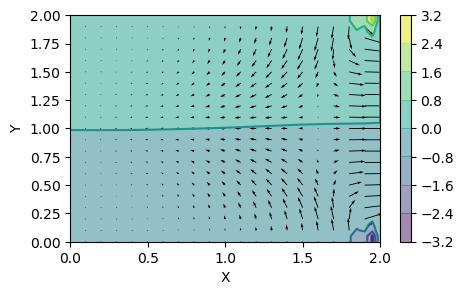

In [5]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

u, v, p = cavity_flow_numba(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu)

fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y');

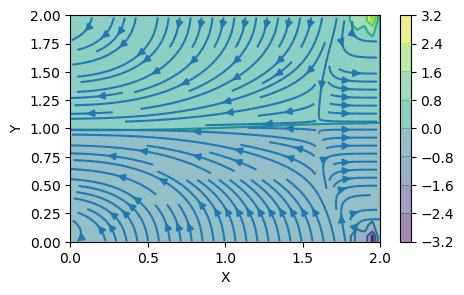

In [6]:
fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.streamplot(X, Y, u, v)
pyplot.xlabel('X')
pyplot.ylabel('Y');

## Call Funtions

## Pure python function

In [7]:
%timeit cavity_flow_pure(nt, u, v, dt, ny, ny, dx, dy, p, rho, nu)

10.2 s ± 277 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Numba accelerator

In [8]:
%timeit cavity_flow_numba(nt, u, v, dt, ny, ny, dx, dy, p, rho, nu)

11.3 ms ± 205 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
